In [56]:
import torch
import random
import numpy as np
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from scipy.stats import norm, skewnorm, skew
from sklearn import linear_model

In [57]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [58]:
from koopman_probabilistic import *
from model_objs import *
import vanilla_benchmark

In [112]:
def rms(x, axis=None):
    if axis is not None:
        return np.sqrt(np.sum(x**2, axis=axis) / x.shape[axis])
    return np.sqrt(np.sum(x**2) / x.size)

In [113]:
import json

with open("GEFCom2017\\GEFCom2017-Qual\\GEFCom2017QualAll.json") as f:
    all_data = json.loads(f.read())

In [114]:
dates = np.array(list(map(pd.Timestamp, all_data["ISONE CA"]["Date"])))
zones = list(all_data.keys())
print(zones)

['ISONE CA', 'ME', 'RI', 'VT', 'CT', 'NH', 'SEMASS', 'WCMASS', 'NEMASSBOST']


In [115]:
zone_name = "ISONE CA"

In [125]:
month_name = "Mar"  # <<<< CHOOSE A MONTH to test
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
month_idx = months.index(month_name)
print("Testing on month", months[month_idx])
test_start_date = pd.Timestamp(f"2017-{month_idx + 1}-01 00:00:00")
test_start = np.argwhere(dates == test_start_date)[0, 0]
test_length = 31 * 24

Testing on month Mar


In [126]:
delay_delta = pd.Timedelta(days=52)
delay = delay_delta.days * 24
train_end_date = test_start_date - delay_delta
num_years = 2
train_start_date = train_end_date.replace(year=train_end_date.year - num_years)
train_start = np.argwhere(dates == train_start_date)[0, 0]
train_length_delta = train_end_date - train_start_date
train_through = train_length_delta.days * 24
pre_length_delta = train_length_delta * 0.5 # the length of time at the beginning of the trianing period to hide from mu
pre_length = pre_length_delta.days * 24

In [127]:
print("ZONE:", zone_name)
data = np.array([all_data[zone_name]["DEMAND"]], dtype=np.float64).T

# rescale data
x_original = data
mean = np.mean(data, axis=0)
rnge = np.max(data, axis=0) - np.min(data, axis=0)
data = (data - np.matlib.repmat(mean, data.shape[0], 1)) / np.matlib.repmat(rnge, data.shape[0], 1)
print("data", data.shape)

ZONE: ISONE CA
data (113952, 1)


<IPython.core.display.Javascript object>


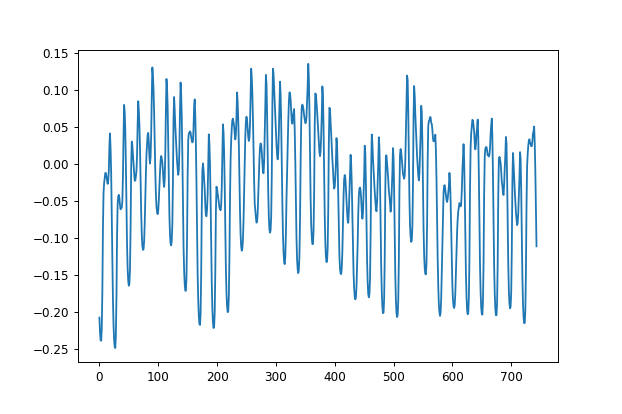

In [128]:

predict_through = train_through + delay + test_length
x = data[train_start:][:predict_through]
xt_trendy = x[:train_through]
annual_means = []
year_midpoints = []
year_length = 365.24 * 24
for year in range(num_years):
    year_midpoints.append(year_length * (year + 0.5))
    annual_means.append(np.mean(xt_trendy[int(year_length * year):int(year_length * (year + 1))]))
reg = linear_model.LinearRegression()
t_vec = np.array(year_midpoints).reshape(-1, 1)
reg.fit(t_vec, annual_means)
t_vec = np.arange(train_through, dtype=np.float64).reshape(-1, 1)  
trend_line = reg.predict(t_vec).reshape(-1, 1)
xt = xt_trendy - trend_line

plt.figure()
plt.plot(x[train_through + delay:])
plt.show()

In [129]:
mask = torch.ones(xt.shape, dtype=torch.uint8)
mask[:pre_length] = 0
num_freqs = [4, 4, 4]
num_fourier = 4
loss_weights = 1 + 0.4 * torch.cos(torch.linspace(0, num_years * 2 * np.pi, xt.shape[0]) - 2 * np.pi * (delay + test_length / 2) / year_length)
recency_weights = 1/(1 + torch.exp((3*xt.shape[0] / 4 - torch.arange(xt.shape[0])) / (xt.shape[0] / 10))) + 0.6
recency_weights[:pre_length] = 1
loss_weights *= recency_weights
print("x", x.shape)
print("xt", xt.shape)

now = ("_".join(str(datetime.now()).split())).replace(":", ".")

### TRAIN ###
model = SkewNormalNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32, loss_weights=loss_weights)

k.find_fourier_omegas(xt, hard_code=[24, 168, 24 * 365.25 / 12, 24 * 365.24])
data_name = "main" + months[month_idx] + zone_name + f"_train_start={train_start}_" + now

x (19536, 1)
xt (17544, 1)
fourier periods: tensor([  24.0000,  168.0000,  730.4999, 8765.7598], dtype=torch.float64)


In [130]:
k.fit(xt, iterations=120, verbose=False, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0, training_mask=mask);

Loss at iteration 10: -0.8793593327899176
Loss at iteration 60: -1.3029373826461632
Loss at iteration 110: -1.7037642055527256
Final loss: -1.724346937415154


In [131]:
fname = "forecasts\\" + data_name + f"trained{train_start}-{train_through}_"
mu_file = fname + "mu.npy"
sigma_file = fname + "sigma.npy"
alpha_file = fname + "alpha.npy"    

### FORECAST ###
params = k.predict(predict_through)
mu_hat, sigma_hat, a_hat = params

mean_hat = model.mean(params)
std_hat = model.std(params)

# ADD BACK THE TREND
trend_line = reg.predict(np.arange(predict_through).reshape(-1, 1)).reshape(-1, 1)
mu_hat += trend_line

np.save(mu_file, mu_hat)
np.save(sigma_file, sigma_hat)
np.save(alpha_file, a_hat)

<IPython.core.display.Javascript object>


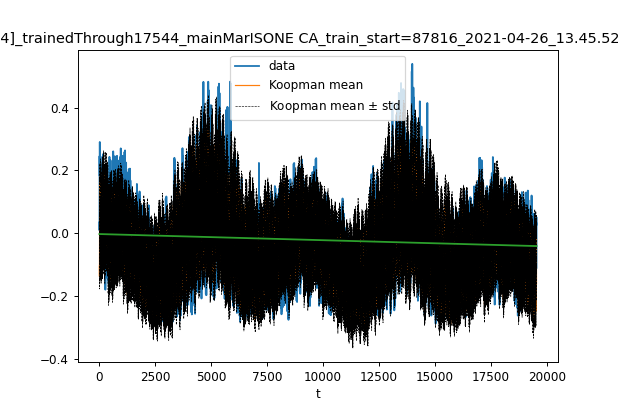

actual overall mean: 0.00010629215911024767  predicted mean: -0.018251209
actual mu train mean: 0.00015669650920871264  predicted mean: -0.026805107


<IPython.core.display.Javascript object>


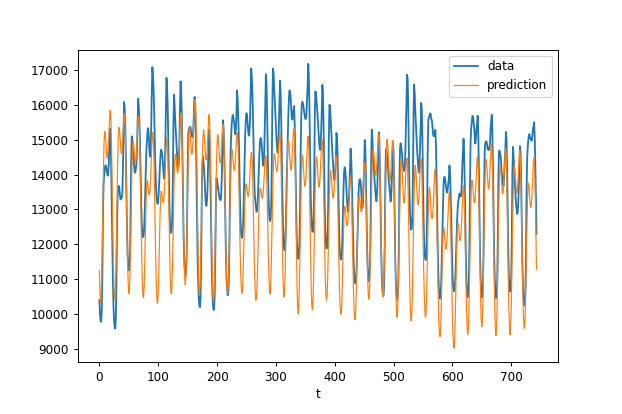

In [133]:
%matplotlib notebook
mean_hat = model.mean(params)
std_hat = model.std(params)

dim = 0
plt.figure()
# plt.scatter(np.arange(-slc), x[slc:], label="data")
plt.plot(x[:predict_through, dim], label="data")
plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
plt.plot(trend_line)
#plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
#plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
plt.xlabel("t")
plt.legend()
plt.show()

### ANALYTICS ###
print("actual overall mean:", np.mean(xt), " predicted mean:", np.mean(mean_hat[:train_through]))
print("actual mu train mean:", np.mean(xt[pre_length:]), " predicted mean:", np.mean(mean_hat[pre_length:train_through]))

### PERFORMANCE ###

#Skew-Normal distribution Rescaling to de-normalize data because pinball loss is not scale-invariant
test_start = train_through + delay
sigh, ah = sigma_hat[test_start: predict_through], a_hat[test_start: predict_through]
delta = ah / np.sqrt(1 + ah ** 2)
muh = mu_hat[test_start: predict_through] * rnge + (rnge - 1) * delta * sigh * np.sqrt(2 / np.pi)
muh = muh + mean - (rnge - 1) * delta * sigh * np.sqrt(2 / np.pi)
sigh = sigh * rnge
mean_hat = model.mean([muh, sigh, ah])
std_hat = model.std([muh, sigh, ah])

plt.figure()
plt.plot(x_original[train_start:][test_start: predict_through], label="data")
plt.plot(mean_hat[:, dim], label="prediction", linewidth=1)
# plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="$\pm$ std", linewidth=0.5)
# plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
# plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
# plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
# plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
plt.xlabel("t")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


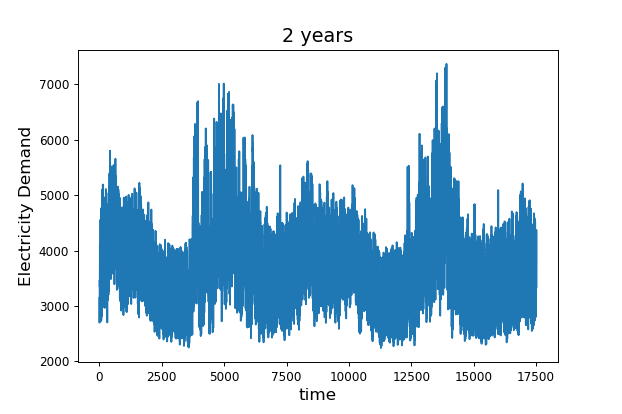

In [48]:
plt.figure()
plt.plot(x_original[:8760 * 2])
plt.title("2 years", fontsize=16)
plt.ylabel("Electricity Demand", fontsize=14)
plt.xlabel("time", fontsize=14)
plt.show()

<IPython.core.display.Javascript object>


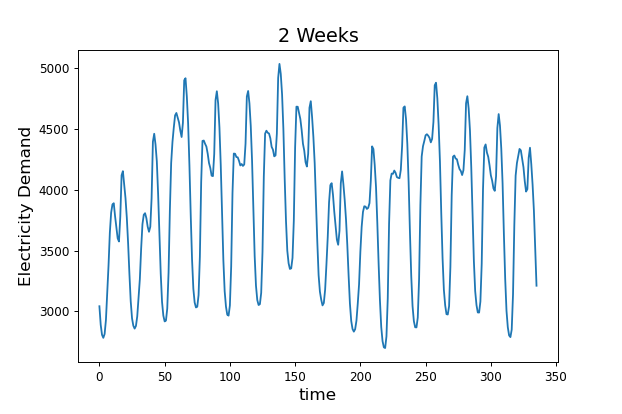

In [49]:
plt.figure()
plt.plot(x_original[9240: 9240 + 168 * 2])
plt.title("2 Weeks", fontsize=16)
plt.ylabel("Electricity Demand", fontsize=14)
plt.xlabel("time", fontsize=14)
plt.show()

In [99]:
def normal_pdf(mu, sigma, x):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))/((2 * np.pi * sigma**2)**0.5)

In [100]:
z_scores = ((x[:train_through] - mean_hat[:train_through]) / std_hat[:train_through])
# z_scores = ((x[train_through:predict_through] - mean_hat[train_through:]) / std_hat[train_through:])[:8760, 0]
# z_scores /= np.std(z_scores)
z_hist, bin_edges = np.histogram(z_scores, bins=40, density=True)
z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2

In [101]:
print(np.std(z_scores))
np.mean(z_scores)

0.8643478605062548


0.5279346986161789

<IPython.core.display.Javascript object>


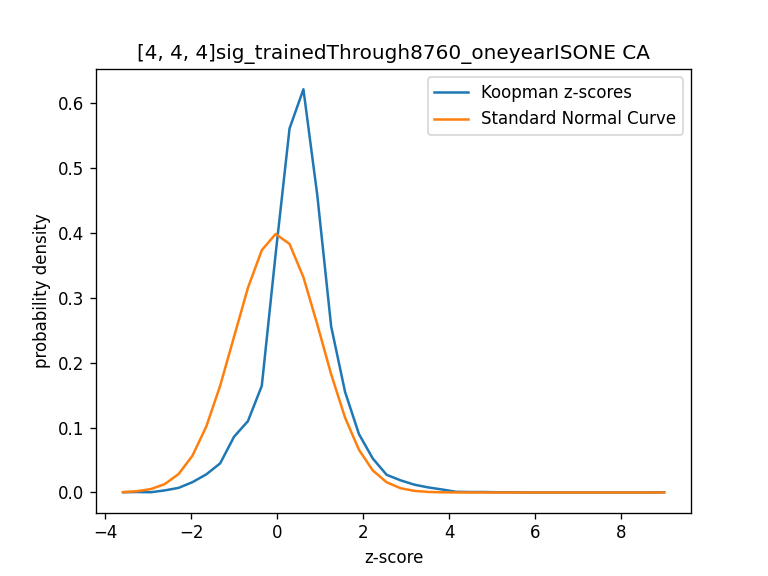

In [102]:
plt.figure()
plt.plot(z_axis, z_hist, label="Koopman z-scores")
plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
plt.title(f"{num_freqs}sig_trainedThrough{train_through}_" + data_name)
plt.xlabel("z-score")
plt.ylabel("probability density")
plt.legend()

In [81]:
mu_hat -= np.mean(mean_hat[:train_through])

# Pinball Loss

In [82]:
def skew_pinball_loss(data, mus, sigmas, alphas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = skewnorm.ppf(q, alphas[i], loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [83]:
def normal_pinball_loss(data, mus, sigmas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = norm.ppf(q, loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

<IPython.core.display.Javascript object>


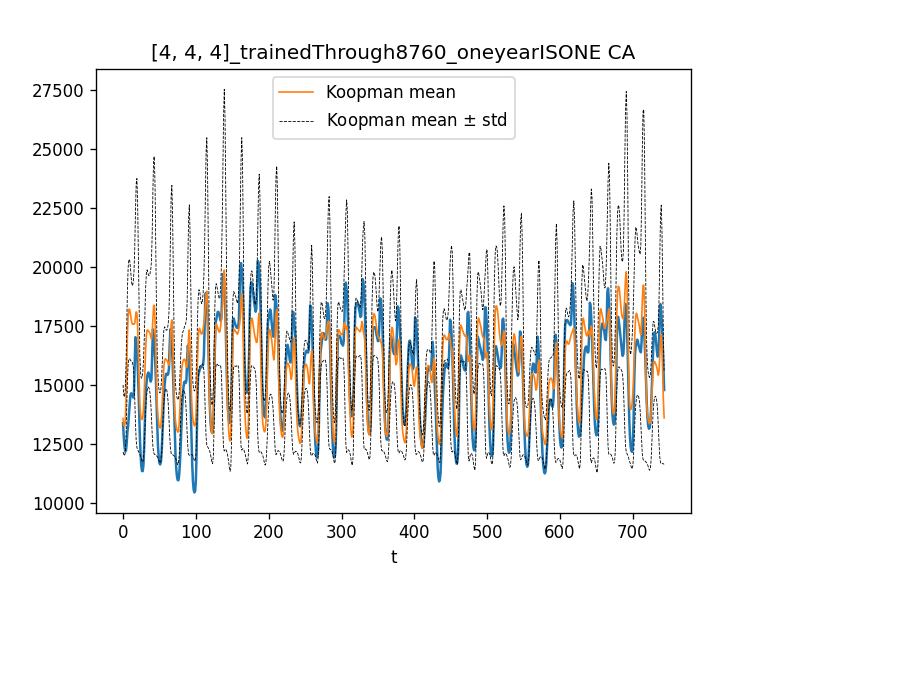

In [84]:
test_start = train_through + delay
# Skew Normal Distribution rescaling
sigh, ah = sigma_hat[test_start: predict_through], a_hat[test_start: predict_through]
delta = ah / (1 + ah ** 2) ** 0.5
muh = mu_hat[test_start: predict_through] * rnge + (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
muh = muh + mean - (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
sigh = sigh * rnge
mean_hat = model.mean([muh, sigh, ah])
std_hat = model.std([muh, sigh, ah])

# # Normal Distribution
# sigh = sigma_hat[test_start: predict_through] * rnge
# muh = mu_hat[test_start: predict_through] * rnge + mean
# mean_hat = model.mean([muh, sigh])
# std_hat = model.std([muh, sigh])

plt.figure()
plt.plot(x_original[train_start:][test_start: predict_through])
plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
# plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
# plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
plt.xlabel("t")
plt.legend()
plt.show()

In [85]:
# loss = normal_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh)
loss = skew_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh, ah)
print(loss)

[441.91462544]


In [87]:
import vanilla_benchmark

vanilla_losses = vanilla_benchmark.get_lossesGEFCom(start=train_start, plot=False)
print(vanilla_losses)

ISONE CA
start: 2014-01-01 00:00:00
ME
start: 2014-01-01 00:00:00
RI
start: 2014-01-01 00:00:00
VT
start: 2014-01-01 00:00:00
CT
start: 2014-01-01 00:00:00
NH
start: 2014-01-01 00:00:00
SEMASS
start: 2014-01-01 00:00:00
WCMASS
start: 2014-01-01 00:00:00
NEMASSBOST
start: 2014-01-01 00:00:00
{'ISONE CA': 381.90378149175325, 'ME': 29.5225280460456, 'RI': 24.10316079531464, 'VT': 15.967894087158326, 'CT': 106.84865130851064, 'NH': 36.62805990777599, 'SEMASS': 48.63787072147622, 'WCMASS': 55.24190168505761, 'NEMASSBOST': 80.30352911316842}


In [88]:
1 - loss/vanilla_losses[zone_name]

# with 52 day gap between training and testing
# 1 - loss / 84.2  # WCMASS +25%
# 1 - loss / 122.8  # NEMASSBOST 39.4%
# 1 - loss / 596  # ISONE 19.4%
# VT: +9.2%
# (old--Monday=0) {'ISONE CA': 523.7428637110866, 'ME': 58.71157246544602, 'RI': 36.73051071209801, 'VT': 22.977155005752657, 'CT': 141.30040329213762, 'NH': 63.25224646477936, 'SEMASS': 65.42717786334023, 'WCMASS': 70.82418918073226, 'NEMASSBOST': 110.09485925971588}


array([-0.15713603])

In [68]:
import os

folder = ".\\forecasts\GEFComFirstQualTest"
a_hat = np.load(os.path.join(folder, "WCMASStrained-17520-8760_[6, 6, 6]alpha.npy"))
mu_hat = np.load(os.path.join(folder, "WCMASStrained-17520-8760_[6, 6, 6]mu.npy"))
sigma_hat = np.load(os.path.join(folder, "WCMASStrained-17520-8760_[6, 6, 6]sigma.npy"))

In [141]:
with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2005-2015.json") as f:
    all_data1 = json.loads(f.read())
    
with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2016.json") as f:
    all_data2 = json.loads(f.read())
    
with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2017.json") as f:
    all_data3 = json.loads(f.read())

In [142]:
zone_name = 'WCMASS'

In [143]:
all_data1[zone_name].keys()

dict_keys(['Date', 'Hour', 'DA_DEMD', 'DEMAND', 'DA_LMP', 'DA_EC', 'DA_CC', 'DA_MLC', 'RT_LMP', 'RT_EC', 'RT_CC', 'RT_MLC', 'DryBulb', 'DewPnt'])

In [144]:
all_data2[zone_name].keys()

dict_keys(['Date', 'Hr_End', 'DA_Demand', 'RT_Demand', 'DA_LMP', 'DA_EC', 'DA_CC', 'DA_MLC', 'RT_LMP', 'RT_EC', 'RT_CC', 'RT_MLC', 'Dry_Bulb', 'Dew_Point'])

In [145]:
all_data3[zone_name].keys()

dict_keys(['Date', 'Hr_End', 'DA_Demand', 'RT_Demand', 'DA_LMP', 'DA_EC', 'DA_CC', 'DA_MLC', 'RT_LMP', 'RT_EC', 'RT_CC', 'RT_MLC', 'Dry_Bulb', 'Dew_Point'])

In [146]:
rename_isone = {'Date': 'Date',
        'Hr_End': 'Hour',
        'DA_Demand': 'DA_DEMD',
        'RT_Demand': 'DEMAND',
        'DA_LMP': 'DA_LMP',
        'DA_EC': 'DA_EC',
        'DA_CC': 'DA_CC',
        'DA_MLC': 'DA_MLC',
        'RT_LMP': 'RT_LMP',
        'RT_EC': 'RT_EC',
        'RT_CC': 'RT_CC',
        'RT_MLC': 'RT_MLC',
        'Dry_Bulb': 'DryBulb',
        'Dew_Point': 'DewPnt',
        'System_Load': 'SYSLoad',
        'Reg_Capacity_Price': 'RegCP'
       }
rename = {'Date': 'Date',
        'Hr_End': 'Hour',
        'DA_Demand': 'DA_DEMD',
        'RT_Demand': 'DEMAND',
        'DA_LMP': 'DA_LMP',
        'DA_EC': 'DA_EC',
        'DA_CC': 'DA_CC',
        'DA_MLC': 'DA_MLC',
        'RT_LMP': 'RT_LMP',
        'RT_EC': 'RT_EC',
        'RT_CC': 'RT_CC',
        'RT_MLC': 'RT_MLC',
        'Dry_Bulb': 'DryBulb',
        'Dew_Point': 'DewPnt',
       }

In [147]:
all_data = all_data1.copy()

In [148]:
for zone in all_data.keys():
    if zone == "ISONE CA":
        for quantity in rename_isone.keys():
            name = rename_isone[quantity]
            all_data[zone][name].extend(all_data2[zone][quantity])
            all_data[zone][name].extend(all_data3[zone][quantity])
    else:
        for quantity in rename.keys():
            name = rename[quantity]
            all_data[zone][name].extend(all_data2[zone][quantity])
            
            all_data[zone][name].extend(all_data3[zone][quantity])
            

In [149]:
x = np.array(all_data[zone_name]["DEMAND"])

In [150]:
x1 = (all_data1[zone_name]["DEMAND"])

In [151]:
len(x2), len(x3), len(x)

(8784, 8760, 113952)

In [152]:
import pandas as pd

In [153]:
dates = np.array(list(map(pd.Timestamp, all_data["ISONE CA"]["Date"])))
hours = np.array(list(pd.Timedelta(hours=h-1) for h in all_data["ISONE CA"]["Hour"]))
dates += hours
dates = list(map(str, dates))

In [154]:
for zone in all_data.keys():
    all_data[zone]["Date"] = dates

In [155]:
all_data[zone_name].keys()

dict_keys(['Date', 'Hour', 'DA_DEMD', 'DEMAND', 'DA_LMP', 'DA_EC', 'DA_CC', 'DA_MLC', 'RT_LMP', 'RT_EC', 'RT_CC', 'RT_MLC', 'DryBulb', 'DewPnt'])

In [156]:
len(all_data[zone]["Date"]) / 8760

13.008219178082191

In [157]:
json_data = json.dumps(all_data)
with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017QualAll.json", "w") as f:
    f.write(json_data)